In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

<p> helper functions and classes </p>

In [8]:
def see_data_stored(data_from_customDataFunction):
  x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
  y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
  #z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
  return x,y

### Prepare data

<p> LOAD LALONDE DATASET </p>

In [9]:
'''
Load the two datasets.
nsw = Male sub sample of treated and control units as used by Lalonde.
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

'''
nsw = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
nswre74 = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")

#Shuffle data sets 
nswre74_pd_df = shuffle(nswre74).reset_index(drop=True)
nsw_pd_df = shuffle(nsw).reset_index(drop=True)


<P> LOAD SIMULATED DATASET</P>

In [10]:
simulated_dataset = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/simulated_experimental_dataset.csv')
simulated_dataset.drop('Unnamed: 0', axis=1, inplace=True)

#### Data pre-processing for NN 

In [11]:
# Subset dataset for ANN training 
nsw_subset1 = ['treat','ageboxcox','education','black','hispanic','married','nodegree','lnre75','lnre78']
nswre74_subset1 = ['treat','ageboxcox','education','black','hispanic','married','nodegree','lnre74','lnre75','lnre78']

nsw_pd_df = nsw_pd_df[nsw_subset1]
nswre74_pd_df= nswre74_pd_df[nswre74_subset1]

nsw_continuos_vars = ['ageboxcox','education','lnre75','lnre78'] 
nswre74_continuos_vars = ['ageboxcox','education','lnre74','lnre75','lnre78'] 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Standardize continous variables 
nsw_pd_df[nsw_continuos_vars] = sc.fit_transform(nsw_pd_df[nsw_continuos_vars])
nswre74_pd_df[nswre74_continuos_vars] = sc.fit_transform(nswre74_pd_df[nswre74_continuos_vars])


# Select variables for ML model 

# Original lalonde (1986) sample 
features_noRe74_df = nsw_pd_df.drop('treat', axis=1)
target_noRe74_df = nsw_pd_df.iloc[:,0]

features_noRe74_array = np.array(features_noRe74_df)
target_noRe74_array = np.array(target_noRe74_df)

FEATURES_noRe74 = torch.tensor(features_noRe74_array)
TARGET_noRe74 = torch.tensor(target_noRe74_array).unsqueeze(1)

# Dehejia and wahba (1999) sample 
features_df = nswre74_pd_df.drop('treat', axis=1)
target_df = nswre74_pd_df.iloc[:,0]

features_array = np.array(features_df)
target_array = np.array(target_df)

FEATURES_Re74 = torch.tensor(features_array)
TARGET_Re74 = torch.tensor(target_array).unsqueeze(1)
print(features_noRe74_array.shape,target_noRe74_df.shape)

#### Custom class for datasets

In [12]:
class CustomDataset:
  def __init__(self,features,target):    
    # load data
    self.features = features             
    self.target = target                
  
  def __len__(self):
    """
    Returns length of dataset.
    """

    return len(self.features)

  def __getitem__(self,idx):

    """
    Returns features and target with index idx.
    """
  
    features = self.features[idx]
    target = self.target[idx]
    return (features, target)
 

In [13]:
class CustomDataset:
  def __init__(self,features,target):    
    
    #import features and targets  
    self.features = features              
    self.target = target               
  
  def __len__(self):
    """
    Returns length of the dataset.
    """
    return len(self.features)

  def __getitem__(self,idx):
    """
    Returns features and target with index idx.
    """
    features = self.features[idx]
    target = self.target[idx]

    # convert data to array
    features_array = np.array(features)
    target_array = np.array(target)
    #convert to tensor 
    features = torch.tensor(features_array).float()
    target = torch.tensor(target_array).float()
    
    return (features, target)

####  Construct NN

<p> set hyper parameters </p>

### Model 

In [14]:
# Define neural netowork class 
class threelayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2,num_hidden_3,num_hidden_4,num_hidden_5):
        super(threelayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.hidden_layer2 =  nn.Linear(num_hidden_2, num_hidden_3) 
        self.hidden_layer3 =  nn.Linear(num_hidden_3, num_hidden_4) 
        self.hidden_layer4 =  nn.Linear(num_hidden_4, num_hidden_5)
        self.hidden_layer5 =  nn.Linear(num_hidden_5, num_classes) 
    
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        self.batchnorm3 = nn.BatchNorm1d(num_hidden_3)
        self.batchnorm4 = nn.BatchNorm1d(num_hidden_4)
        self.batchnorm5 = nn.BatchNorm1d(num_hidden_5)
    
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        # second hidden layer and output
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.hidden_layer3(x)
        x = self.relu_activation(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.hidden_layer4(x)
        x = self.relu_activation(x)
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = self.hidden_layer5(x)
        x = self.output_activation(x)
        return x


class twoLayerNN(nn.Module):
    def __init__(self,num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

class ONELayerNN(nn.Module):
    def __init__(self,num_features, num_classes, num_hidden_1):
        super(ONELayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                                               
        self.out_layer =  nn.Linear(num_hidden_1, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()      

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





<p> NN helper functions </p>

In [15]:
# Function to reset model weights 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [16]:
# Function to initialise model weights 
def initialize_weights(m):
    classname = m.__class__.__name__
    # For every linear layer in the mdoel   
    if classname.find('Linear') != -1:
     n = m.in_features
     y = 1.0/np.sqrt(n)
     m.weight.data.uniform_(-y, y)
     m.bias.data.fill_(0)
    

### K-FOLD Cross validation 

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN

resample=SMOTEENN(random_state=0)


<p> Plot loss and accuracy </p>

### Model training 2 - Train, Test Split, no Kfold , with imbalanced dalaloader 

In [18]:
# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}

train_precision_dict = {}
train_recall_dict = {}
train_f1_dict = {}
train_mse_dict = {}

test_precision_dict = {}
test_recall_dict = {}
test_f1_dict = {}
test_mse_dict = {}


foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}

In [19]:
nswre74_pd_df

,treat,ageboxcox,education,black,hispanic,married,nodegree,lnre74,lnre75,lnre78
0,1,0.227596,0.403799,1,0,0,1,-0.586159,-0.722547,0.086256
1,0,0.227596,1.140460,1,0,1,0,-0.586159,-0.722547,-1.439254
2,0,-0.759174,-1.069522,0,1,0,1,-0.586159,-0.722547,0.787656
3,1,-1.017875,-0.332862,1,0,0,1,-0.586159,0.897565,0.781508
4,0,1.280153,-0.332862,1,0,0,1,-0.586159,-0.722547,0.776230
...,...,...,...,...,...,...,...,...,...,...
400,0,-1.625175,-1.806183,1,0,0,1,-0.586159,-0.722547,0.806577
401,1,-0.759174,0.403799,1,0,0,1,-0.586159,-0.722547,0.604995
402,1,0.996291,-1.069522,1,0,0,1,1.941680,1.622094,0.821608
403,0,0.227596,0.403799,1,0,0,1,2.037038,1.462755,-0.045761


In [20]:
# Subset dataset for ANN training 
nswre74_pd_df = nswre74_pd_df.sample(frac = 1,random_state=42).reset_index(drop=True)
nsw_pd_df = nsw_pd_df.sample(frac = 1,random_state=42).reset_index(drop=True)

nsw_subset1 = ['treat','ageboxcox','education','black','hispanic','married','nodegree','lnre75','lnre78']
nswre74_subset1 = ['treat','ageboxcox','education','black','hispanic','married','nodegree','lnre74','lnre75','lnre78']

nsw_pd_df = nsw_pd_df[nsw_subset1]
nswre74_pd_df= nswre74_pd_df[nswre74_subset1]

nsw_continuos_vars = ['ageboxcox','education','lnre75','lnre78'] 
nswre74_continuos_vars = ['ageboxcox','education','lnre74','lnre75','lnre78'] 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Standardize continous variables 
nsw_pd_df[nsw_continuos_vars] = sc.fit_transform(nsw_pd_df[nsw_continuos_vars])
nswre74_pd_df[nswre74_continuos_vars] = sc.fit_transform(nswre74_pd_df[nswre74_continuos_vars])


In [58]:
from torchvision import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler

# Train test split 
train_dataset, test_dataset = train_test_split(nswre74_pd_df,  test_size=0.3, random_state=0)


# Features and targets for train data
features_train_Re74_df = train_dataset.drop('treat', axis=1)
target_train_Re74_df = train_dataset.iloc[:,0]

features_train_Re74_array = np.array(features_train_Re74_df)
target_train_Re74_array = np.array(target_train_Re74_df)

FEATURES_TRAIN_Re74 = torch.tensor(features_train_Re74_array)
TARGET_TRAIN_Re74 = torch.tensor(target_train_Re74_array).unsqueeze(1)

# Features and targets for test data
features_test_Re74_df = test_dataset.drop('treat', axis=1)
target_test_Re74_df = test_dataset.iloc[:,0]

features_test_Re74_array = np.array(features_test_Re74_df)
target_test_Re74_array = np.array(target_test_Re74_df)

FEATURES_test_Re74 = torch.tensor(features_test_Re74_array)
TARGET_test_Re74 = torch.tensor(target_test_Re74_array).unsqueeze(1)

#upsample
FEATURES_TRAIN_Re74, TARGET_TRAIN_Re74 = resample.fit_resample(FEATURES_TRAIN_Re74, TARGET_TRAIN_Re74)

train_data = CustomDataset(features = FEATURES_TRAIN_Re74,target = TARGET_TRAIN_Re74)
test_data = CustomDataset(features = FEATURES_test_Re74,target = TARGET_test_Re74)


In [59]:
FEATURES_TRAIN_Re74.shape

(84, 9)

In [30]:
NUM_FEATURES = FEATURES_TRAIN_Re74.shape[1]
NUM_HIDDEN_1 = 5
NUM_HIDDEN_2 = 5
NUM_CLASSES = 1
NUM_EPOCHS = 200
BATCH_SIZE = 512
#BATCH_SIZE = 480
#BATCH_SIZE =  512
LEARNING_RATE = 0.001
#LEARNING_RATE = 0.0182
#WEIGHT_DECAY = 0.005
WEIGHT_DECAY = 0.0182

In [32]:
from torchsampler import ImbalancedDatasetSampler
import sklearn.metrics as metrics

trainloader = DataLoader(train_data,  batch_size=BATCH_SIZE)
testloader = DataLoader(test_data,batch_size=BATCH_SIZE)

# Instanstiate model 

model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.to(device)
# Reset weights 
model.apply(reset_weights)
model.apply(initialize_weights)
#Initialise optimiser and loss function 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()

metrics = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}


In [33]:
import warnings

# Functions for ANN training 
# def get loss each epoch 
def store_loss(loss,features,dataloader,running_loss,epoch,dataloader_id):
    if dataloader.__hash__() == dataloader_id:
        x = running_loss
        x += loss.item()*features.size(0)
        avg_loss = x / len(trainloader.sampler)
        training_loss_dict[(epoch)] = avg_loss
    else:
        x = running_loss
        x += loss.item()*features.size(0)
        avg_loss = x / len(trainloader.sampler)
        validation_loss_dict[(epoch)] = avg_loss


from sklearn import metrics

# def get metrics 
def store_metrics(pred,target,dataloader,epoch,dataloader_id):
    
    if dataloader.__hash__() == dataloader_id:
        # Precision
        precision = metrics.precision_score(target,pred)
        train_precision_dict[(epoch)] = precision
        # Recall
        recall = metrics.recall_score(target,pred)
        train_recall_dict[(epoch)] = recall
        # MSE 
        mse = metrics.mean_squared_error(target,pred)
        train_mse_dict[(epoch)] = mse
        # F1
        f1 = metrics.f1_score(target,pred)
        train_f1_dict[(epoch)] = f1
        warnings.filterwarnings('ignore')
    else:
        precision = metrics.precision_score(target,pred)
        test_precision_dict[(epoch)] = precision
        # Recall
        recall = metrics.recall_score(target,pred)
        test_recall_dict[(epoch)] = recall
        # MSE 
        mse = metrics.mean_squared_error(target,pred)
        test_mse_dict[(epoch)] = mse
        # F1
        f1 = metrics.f1_score(target,pred)
        test_f1_dict[(epoch)] = f1
        warnings.filterwarnings('ignore')



In [54]:
# Define train and test
def trainTestModel(train_loader, test_loader):
    
    model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2) 
    #model = ONELayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1) 
    model.to(device)
    model.apply(initialize_weights)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss()
    # train & test process
    def train(trainloader,epoch,accuracy,dataloader_id):
        model.train()
        correct = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.float().to(device), target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output
            target = target
            loss = criterion(output, target)
            store_loss(loss,data,trainloader,running_loss,epoch,dataloader_id) # loss for plotting
            pred = (output >= 0.5).type(torch.uint8)
            store_metrics(pred,target,trainloader,epoch,dataloader_id)
            correct += pred.eq(target.view_as(pred)).sum().item()   
            loss.backward()
            optimizer.step()

        train_acc = 100. * correct / len(trainloader.dataset)
        training_accuracy_dict[(epoch)] = train_acc
        #store_accuracy(pred,target,correct_store,trainloader,epoch,accuracy,dataloader_id) # accuracy for plotting

    def test(testloader,epoch,accuracy,dataloader_id):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.float().to(device), target.float().to(device)
                output = model(data)
                loss = criterion(output , target)
                store_loss(loss,data,test_loader,running_loss,epoch,dataloader_id) # loss for plotting
                pred = (output >= 0.5).type(torch.uint8) 
                store_metrics(pred,target,testloader,epoch,dataloader_id)
                correct += pred.eq(target.view_as(pred)).sum().item()
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())
        
        #store_accuracy(pred,target,correct_store,trainloader,epoch,accuracy,dataloader_id) # accuracy for plotting  
        test_acc = 100. * correct / len(testloader.dataset)
        validation_accuracy_dict[(epoch)] = test_acc
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []
    trainloader_id = train_loader.__hash__()    
    for epoch in range(1, NUM_EPOCHS + 1):
        running_loss = 0.0
        accuracy = 0
        train(train_loader,epoch,accuracy,trainloader_id)
        test_acc, confusion_mtx = test(test_loader,epoch,accuracy,trainloader_id)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
  

In [55]:
trainTestModel(train_loader=trainloader,test_loader=testloader)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [55]:
# Create lists
train_accuracy_list = list(training_accuracy_dict.values())
test_accuracy_list = list(validation_accuracy_dict.values())

train_loss_list = list(training_loss_dict.values())
test_loss_list = list(validation_loss_dict.values())

train_precision_list = list(train_precision_dict.values()) 
train_recall_list = list(train_recall_dict.values()) 

train_f1_list = list(train_f1_dict.values())
train_mse_list = list(train_mse_dict.values())

test_precision_list = list(test_precision_dict.values()) 
test_recall_list = list(test_recall_dict.values()) 
test_f1_list = list(test_f1_dict.values())
test_mse_list = list(test_mse_dict.values())


In [56]:
print(f'avg train acc: {np.mean(train_accuracy_list):.2f} | 'f'avg test acc : {np.mean(test_accuracy_list):.2f} | '
      f'avg train prec : {np.mean(train_precision_list):.2f} |'f'avg test prec : {np.mean(test_precision_list):.2f} |'
      f' avg train mse: {np.mean(train_mse_list):.2f} | ' f'avg test mse: {np.mean(test_mse_list):.2f} |'
      f' avg train F1: {np.mean(train_f1_list):.2f} | 'f' avg test F1: {np.mean(test_f1_list):.2f}')

avg train acc: 57.02 | avg test acc : 52.02 | avg train prec : 0.49 |avg test prec : 0.36 | avg train mse: 0.43 | avg test mse: 0.48 | avg train F1: 0.46 |  avg test F1: 0.28


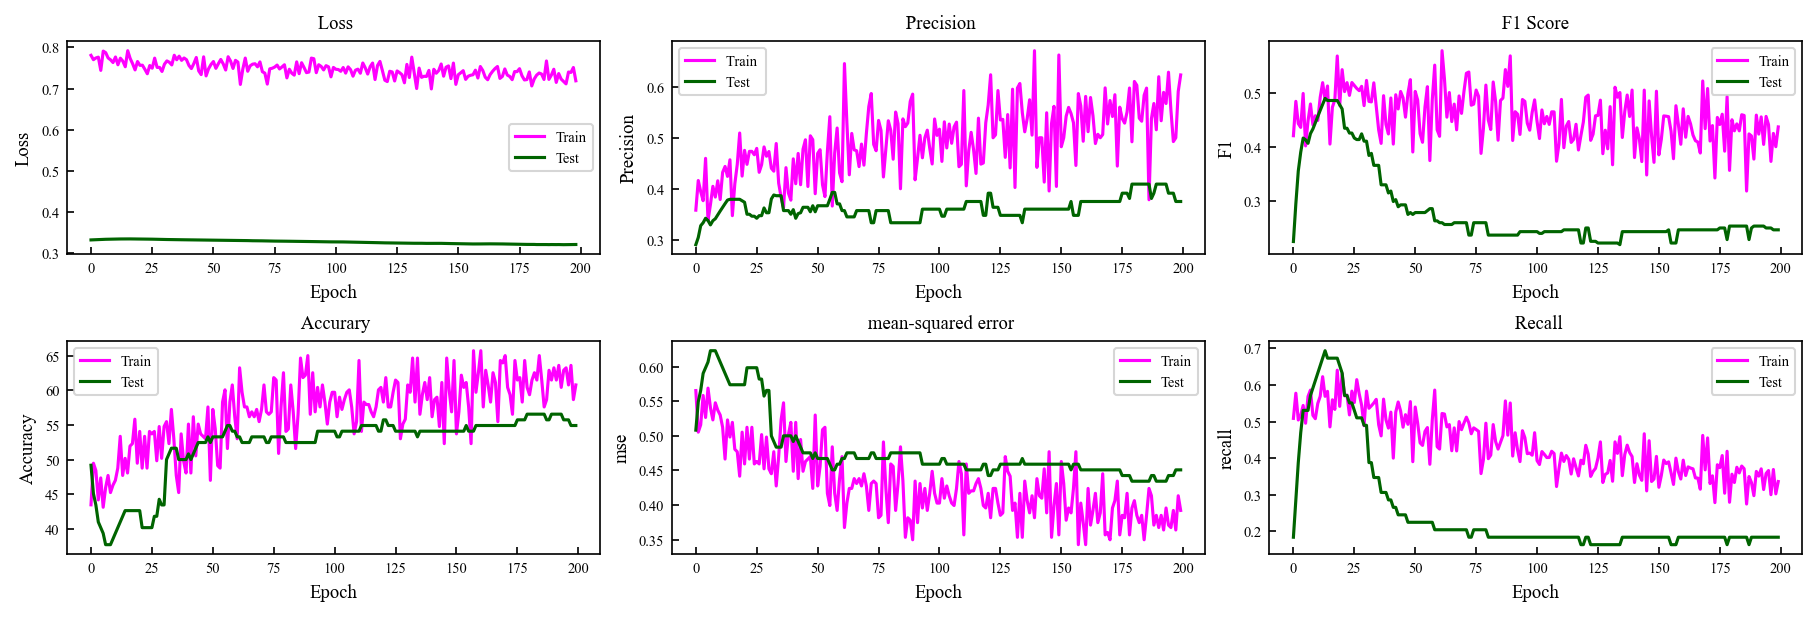

In [57]:
from tueplots import axes, bundles , figsizes, fonts,fontsizes
# Create plots of all metrics 

# Global plot settings 

fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,4))
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update(fontsizes.neurips2022())


#x-axis
xrange = range(0,NUM_EPOCHS+1)

# Loss
ax[0,0].plot(range(0,len(train_loss_list)-1), train_loss_list[:-1], label='Train',color='magenta')
ax[0,0].plot(range(0,len(test_loss_list)-1), test_loss_list[:-1], label='Test',color = 'darkgreen')
ax[0,0].legend()
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title(' Loss')

# Precison 
ax[0,1].plot(range(0,len(train_precision_list)), train_precision_list, label='Train ',color='magenta')
ax[0,1].plot(range(0,len(test_precision_list)), test_precision_list, label='Test ',color = 'darkgreen')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Precision')
ax[0,1].set_title(' Loss')
ax[0,1].set_title(' Precision')
ax[0,1].legend()
# F1 
ax[0,2].plot(range(0,len(train_f1_list)), train_f1_list, label='Train',color='magenta')
ax[0,2].plot(range(0,len(test_f1_list)), test_f1_list, label='Test',color = 'darkgreen')
ax[0,2].set_xlabel('Epoch')
ax[0,2].set_ylabel('F1')
ax[0,2].set_title(' Loss')
ax[0,2].set_title(' F1 Score ')
ax[0,2].legend()
# Accuracy 
ax[1,0].plot(range(0,len(train_accuracy_list)), train_accuracy_list, label='Train',color='magenta')
ax[1,0].plot(range(0,len(test_accuracy_list)), test_accuracy_list, label='Test',color = 'darkgreen')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_title(' Accurary')
ax[1,0].legend()
# MSE
ax[1,1].plot(range(0,len(train_mse_list)), train_mse_list, label='Train',color='magenta')
ax[1,1].plot(range(0,len(test_mse_list)), test_mse_list, label='Test',color = 'darkgreen')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('mse')
ax[1,1].set_title(' mean-squared error')
ax[1,1].legend()
# recall
ax[1,2].plot(range(0,len(train_recall_list)), train_recall_list, label='Train',color='magenta')
ax[1,2].plot(range(0,len(test_recall_list)), test_recall_list, label='Test',color = 'darkgreen')
ax[1,2].set_xlabel('Epoch')
ax[1,2].set_ylabel('recall')
ax[1,2].set_title(' Recall')
ax[1,2].legend()

<function matplotlib.pyplot.show(close=None, block=None)>

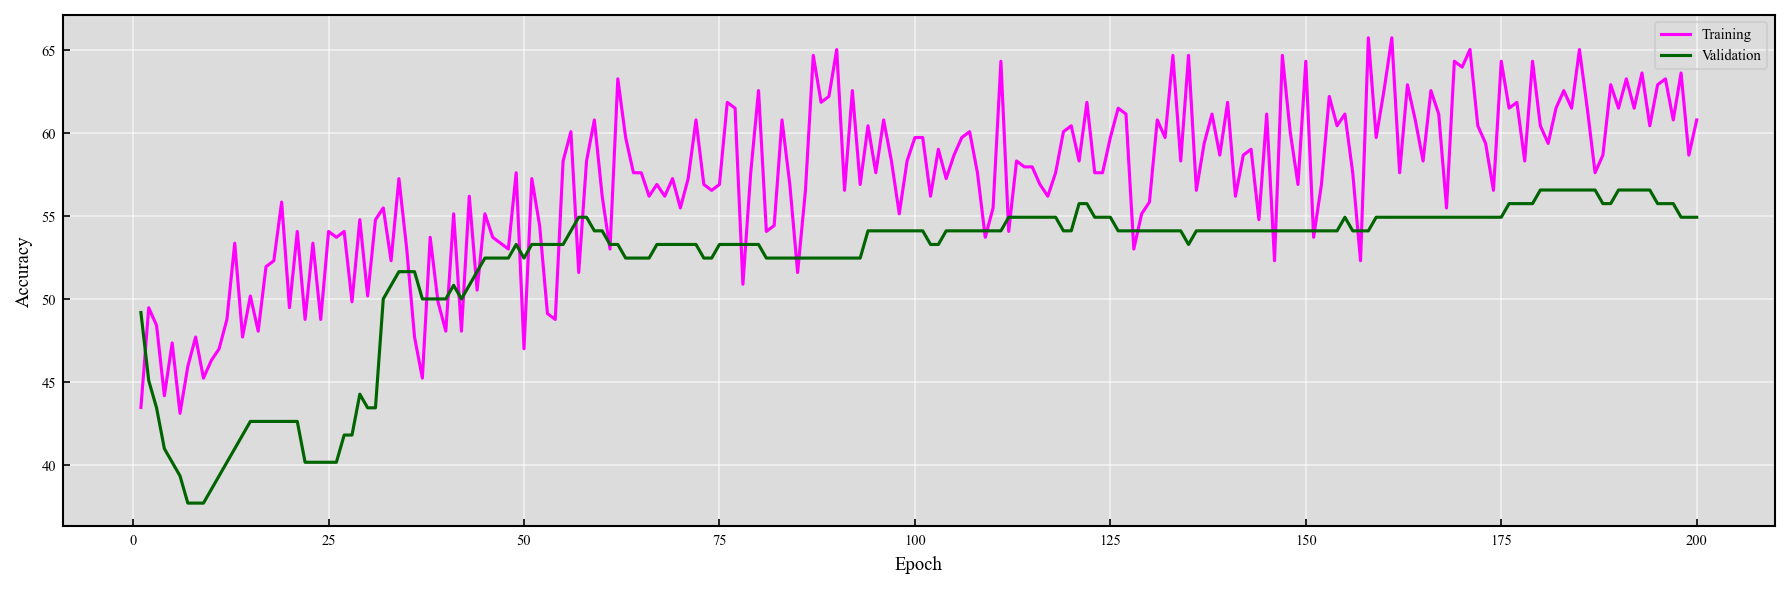

In [58]:
fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

epochs_train = len(train_accuracy_list)
epochs_val = len(test_accuracy_list)

plt.plot(np.arange(1, epochs_train+1),train_accuracy_list, label='Training',color='magenta')
plt.plot(np.arange(1, epochs_val+1),test_accuracy_list, label='Validation',color='darkgreen')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show

In [60]:
# Plot training and validation losses 

# Use to plots to clean up the presentation 
from tueplots import bundles 
from tueplots import figsizes
from tueplots import axes

# tueplots paramaters 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(axes.lines())
figsizes.neurips2021(nrows=3)["figure.figsize"]

plt.rcParams.update({"figure.dpi": 150})

fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

ax.plot(train_loss_list[:-1], label='Training loss',color='magenta')
ax.plot(test_loss_list[:-1], label='Validation loss',color = 'darkgreen')

ax.set_title(' Training and validation loss ')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()


plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

FileNotFoundError: missing font metrics file: ptmr7t

<Figure size 1800x600 with 1 Axes>